In [ ]:
!pip install word2number

  Preparing metadata (setup.py) ... done
  Created wheel for word2number: filename=word2number-1.1-py3-none-any.whl size=5569 sha256=af962dcd30cc8edc671244cf7f507759f47ac81c50bc134657701a942f7bafc8
  Stored in directory: /root/.cache/pip/wheels/84/ff/26/d3cfbd971e96c5aa3737ecfced81628830d7359b55fbb8ca3b
Successfully built word2number


In [ ]:
import nltk
import csv
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
from word2number import w2n
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag, pos_tag_sents
from wordcloud import WordCloud, STOPWORDS
import tensorflow_hub as hub
from keras.models import Sequential
from keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Embedding, Input, dot
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
!pip3 show tensorflow

Name: tensorflow
Version: 2.12.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, jax, keras, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine-rl


In [ ]:
import csv
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')

In [ ]:
train_df.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [ ]:
train_df.shape

(3911, 8)

In [ ]:
train_df.describe()

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
count,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000
mean,3.127077,3.028254,3.235745,3.116850,3.032856,3.081053
std,0.662542,0.644399,0.583148,0.655997,0.699841,0.671450
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.500000,2.500000,3.000000,2.500000,2.500000,2.500000
50%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
75%,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [ ]:
train_df.isnull().sum().sort_values(ascending=False)

text_id        0
full_text      0
cohesion       0
syntax         0
vocabulary     0
phraseology    0
grammar        0
conventions    0
dtype: int64

In [ ]:
# import nltk
# print(nltk.find('corpora/wordnet.zip')) --> to check if wordnet is unzipped and available
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

unzip:  cannot find or open /usr/share/nltk_data/corpora/wordnet.zip, /usr/share/nltk_data/corpora/wordnet.zip.zip or /usr/share/nltk_data/corpora/wordnet.zip.ZIP.


In [ ]:
def check_num(x):
    """
    Remove numbers from list
    :param x:list of words
    :return: list of words without any numbers

    E.g: ETL.check_num(['five','four','day','sun']) will return ['day','sun']
    """
    word_list = []
    remove_list = []
    for i in x:
        try:
            w2n.word_to_num(i)
            remove_list.append(i)
        except ValueError:
            word_list.append(i)
    return "".join(word_list)

In [ ]:
## Clean the text
def text_preprocess(sentence):
    # convert text to lowercase
    sentence=str(sentence)
    sentence = sentence.lower()

    # A tokenizer that splits a string using a regular expression,
    # which matches either the tokens or the separators between tokens.
    tokenizer = nltk.RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(sentence)

    # Remove stopwords
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]

    # Stemming the words (eg. Studies => Studi)
    stemmer = PorterStemmer()
    stem_words=[stemmer.stem(w) for w in filtered_words]

    # Lemmatize (eg. Studies => Study)
    lemmatizer = WordNetLemmatizer()
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]

    return " ".join(filtered_words)

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Clean text, check & remove numbers
train_df['clean_text'] = train_df['full_text'].apply(text_preprocess)
train_df['clean_text'] = train_df['clean_text'].map(lambda x: check_num(x))
train_df['clean_text'] = train_df['clean_text'].str.replace('http','')
train_df['clean_text'] = train_df['clean_text'].str.replace('https','')
train_df.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,clean_text
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,think students would benefit learning home won...
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,problem change let best matter happening chang...
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,dear principal change school policy grade aver...
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,best time life become agree greatest accomplis...
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,small act kindness impact people change people...


In [ ]:
## List the top 25 frequest keywords in full_text column
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [ ]:
## Get top 25 Frequent keywords
wordcount_list = train_df['clean_text'].tolist()
freq_keywords = get_top_n_words(wordcount_list,25)

df_wordcounts = pd.DataFrame(freq_keywords, columns=['words','freq'])
df_wordcounts.head(5)

,words,freq
0,people,15322
1,students,13130
2,school,12969
3,time,8574
4,good,8436


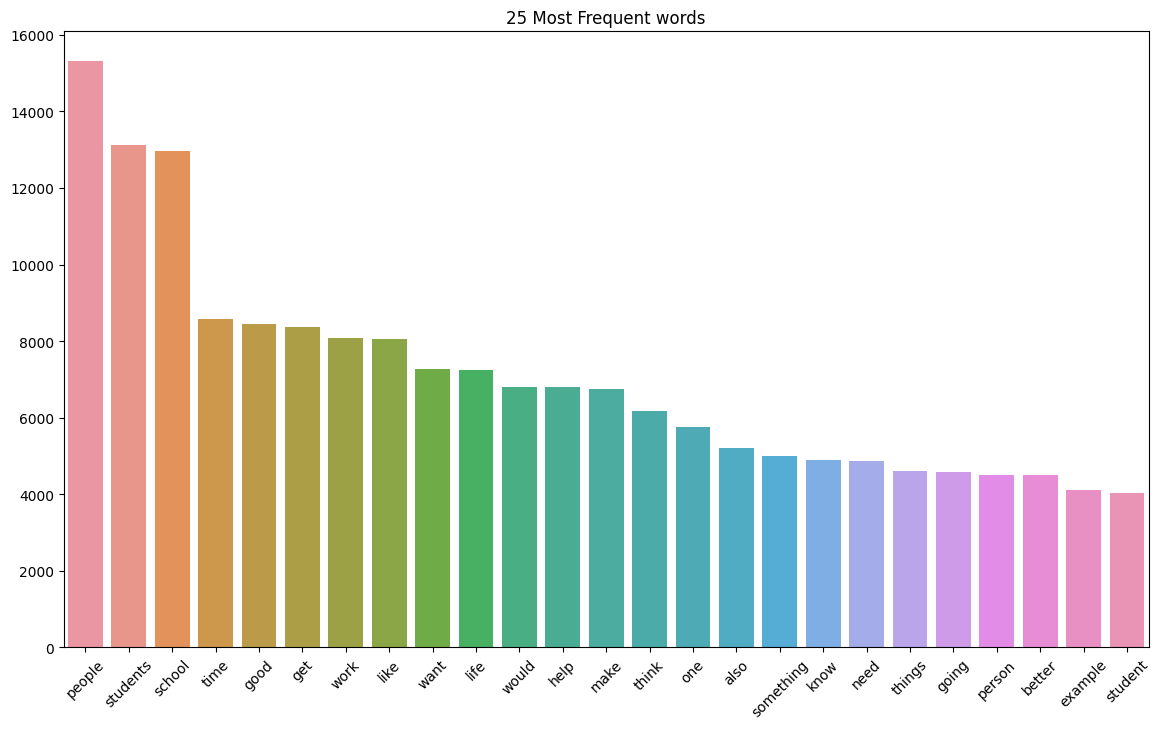

In [ ]:
import matplotlib.pyplot as plt
# create bar plot of top 20 words
fig, ax = plt.subplots(figsize = (14,8))
_ = sns.barplot(data = df_wordcounts, x = 'words', y = 'freq', ax = ax)
labels = [item.get_text() for item in ax.get_xticklabels()]
ax.set_xticklabels(labels, rotation = 45)
ax.set_title("25 Most Frequent words")
ax.set_xlabel("")
ax.set_ylabel("")
plt.show(fig)

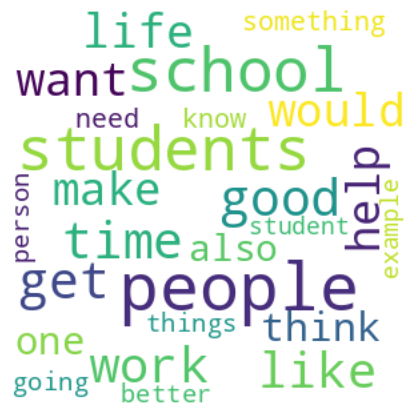

In [ ]:
# Wordcloud
wordcloud = WordCloud(width = 300,
                      height = 300,
                      background_color='white',
                      max_font_size=50, max_words=150)

wordcloud = wordcloud.generate_from_frequencies(df_wordcounts.set_index('words').freq)

# plot words
plt.figure(figsize=(6,4),facecolor = 'white', edgecolor='blue')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [ ]:
def get_tfhub_embeddings(hub_model, input_values):
    """
    :param hub_model: loaded TF HUB model to be used for embedding lookups
    :param input: sentences to look up embeddings
    Return tfHub model embeedings
    """
    return hub_model(input_values)

In [ ]:
# Building our embedding layer with TF Hub
def embed(input):
  return model(input)

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
tf_model = hub.load(module_url)
print ("module %s loaded" % module_url)


module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [ ]:
# Split the dataset
X_train, X_val, y_train, y_val = train_test_split(train_df['clean_text'],
                                                  train_df[['cohesion', 'syntax', 'vocabulary',
                                                              'phraseology', 'grammar', 'conventions']],
                                                  test_size=0.2,
                                                  random_state=42)

In [ ]:
X_train.shape

(3128,)

In [ ]:
X_val.shape

(783,)

In [ ]:
y_train.shape

(3128, 6)

In [ ]:
y_val.shape

(783, 6)

In [ ]:
# Train embeddings
train_embeddings = get_tfhub_embeddings(tf_model, X_train)

In [ ]:
train_embeddings

<tf.Tensor: shape=(3128, 512), dtype=float32, numpy=
array([[-0.02030706, -0.06276024,  0.05850618, ..., -0.05989736,
        -0.05763413,  0.04488133],
       [ 0.04243866, -0.04895128, -0.04879124, ...,  0.04888656,
        -0.04892056,  0.04045769],
       [-0.01545733, -0.06186138,  0.00869186, ..., -0.02695067,
        -0.02145453,  0.02933881],
       ...,
       [ 0.03809927, -0.05193041,  0.05162708, ...,  0.04609749,
        -0.04408437, -0.04456358],
       [ 0.04691554, -0.04691561, -0.04690049, ...,  0.04690446,
        -0.04691566, -0.04691566],
       [ 0.02195081, -0.06159687,  0.0456199 , ..., -0.01428163,
        -0.01393795, -0.04625296]], dtype=float32)>

In [ ]:
train_embeddings.shape

TensorShape([3128, 512])

In [ ]:
# Val embeddings
val_embeddings = get_tfhub_embeddings(tf_model, X_val)

In [ ]:
val_embeddings

<tf.Tensor: shape=(783, 512), dtype=float32, numpy=
array([[-0.04551474, -0.05303006,  0.05301534, ..., -0.05180794,
        -0.05301658,  0.04689324],
       [ 0.06358184, -0.06963202,  0.03173317, ...,  0.02603714,
        -0.07032435,  0.01562743],
       [ 0.01247489, -0.05968821, -0.00218256, ..., -0.01090817,
        -0.05846686, -0.04300472],
       ...,
       [ 0.03636789, -0.05447835,  0.02963859, ...,  0.05266872,
        -0.00765883, -0.01270793],
       [ 0.05934792, -0.06195728,  0.03348529, ...,  0.01394424,
        -0.06054487, -0.0482785 ],
       [-0.04915535, -0.05633991, -0.01206606, ..., -0.05646549,
        -0.05516211, -0.01542348]], dtype=float32)>

In [ ]:
val_embeddings.shape

TensorShape([783, 512])

In [ ]:
input_dim = len(train_embeddings[0])
inputs = Input(shape=(input_dim,))

model=Sequential()
model.add(Embedding(input_dim=50,output_dim=8))
model.add(LSTM(128,dropout=0.4,recurrent_dropout=0.4))

model.add(Dense(6,activation='relu'))
model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 8)           400       
                                                                 
 lstm (LSTM)                 (None, 128)               70144     
                                                                 
 dense (Dense)               (None, 6)                 774       
                                                                 
Total params: 71,318
Trainable params: 71,318
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
batch_size=128
model.fit(train_embeddings, y_train, epochs=1, batch_size=batch_size, verbose=1)

25/25 [==============================] - 88s 3s/step - loss: 5.3001 - accuracy: 0.2778


In [ ]:
# # Fit the model
# batch_size=128
# model.fit(train_embeddings, y_train, epochs=10, batch_size=batch_size, verbose=1,
#          validation_data=(np.array(val_embeddings), np.array(y_val))
#          )

In [ ]:
test_df.head()

,text_id,full_text
0,0000C359D63E,when a person has no experience on a job their...
1,000BAD50D026,Do you think students would benefit from being...
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde..."


In [ ]:
# Clean text, check & remove numbers
test_df['clean_text'] = test_df['full_text'].apply(text_preprocess)
test_df['clean_text'] = test_df['clean_text'].map(lambda x: check_num(x))
test_df['clean_text'] = test_df['clean_text'].str.replace('http','')
test_df['clean_text'] = test_df['clean_text'].str.replace('https','')
test_df.head()

,text_id,full_text,clean_text
0,0000C359D63E,when a person has no experience on a job their...,person experience job always going good people...
1,000BAD50D026,Do you think students would benefit from being...,think students would benefit able attend class...
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde...",thomas jefferson states wonderful much get don...


In [ ]:
test_df['clean_text']

0    person experience job always going good people...
1    think students would benefit able attend class...
2    thomas jefferson states wonderful much get don...
Name: clean_text, dtype: object

In [ ]:
# Train embeddings
test_embeddings = get_tfhub_embeddings(tf_model, test_df["clean_text"])

In [ ]:
preds = model.predict(test_embeddings)

1/1 [==============================] - 0s 431ms/step


In [ ]:
preds

array([[3.1268702, 0.       , 3.55022  , 2.937745 , 2.9168682, 3.0678525],
       [3.1268702, 0.       , 3.55022  , 2.937745 , 2.9168682, 3.0678525],
       [3.1268702, 0.       , 3.55022  , 2.937745 , 2.9168682, 3.0678525]],
      dtype=float32)

In [ ]:
# Create a submission file
submission_df = pd.DataFrame(preds, columns=['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions'])

In [ ]:
submission_df.insert(0, 'text_id', test_df['text_id'])

In [ ]:
submission_df

,text_id,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,3.12687,0.0,3.55022,2.937745,2.916868,3.067852
1,000BAD50D026,3.12687,0.0,3.55022,2.937745,2.916868,3.067852
2,00367BB2546B,3.12687,0.0,3.55022,2.937745,2.916868,3.067852
